In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_csv('data/data.csv', low_memory=False)

# Domain Specific Clusters (Subset datasets: 31 Questions in Total for 3 Clusters)

## Subset the combined dataset and process the data

### Subset and Process

In [3]:
# Define all index ranges and individual indices
mental_ix  = list(range(25, 30)) + [83, 105]
home_ix    = list(range(88, 91)) + list(range(98, 102)) + [103]
social_ix  = [13, 15, 18] + list(range(19, 25)) + [87, 102, 104]
health_ix  = list(range(75, 78)) + [84]

# Combine and sort unique indices
all_indices = sorted(set(mental_ix + home_ix + social_ix + health_ix))

# Subset columns by index
dat1 = dat.iloc[:, all_indices].copy()

In [4]:
num_rows_with_na = dat1.isna().any(axis=1).sum()
num_rows_with_na

np.int64(10900)

In [5]:
dat_cleaned = dat1.dropna(axis=0, how='any')
dat_cleaned.shape

(9203, 31)

In [6]:
dat_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9203 entries, 1 to 11426
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q14     9203 non-null   float64
 1   Q16     9203 non-null   float64
 2   Q19     9203 non-null   float64
 3   Q20     9203 non-null   float64
 4   Q21     9203 non-null   float64
 5   Q22     9203 non-null   float64
 6   Q23     9203 non-null   float64
 7   Q24     9203 non-null   float64
 8   Q25     9203 non-null   float64
 9   Q26     9203 non-null   float64
 10  Q27     9203 non-null   float64
 11  Q28     9203 non-null   float64
 12  Q29     9203 non-null   float64
 13  Q30     9203 non-null   float64
 14  Q76     9203 non-null   float64
 15  Q77     9203 non-null   float64
 16  Q78     9203 non-null   float64
 17  Q84     9203 non-null   float64
 18  Q85     9203 non-null   float64
 19  Q88     9203 non-null   float64
 20  Q89     9203 non-null   float64
 21  Q90     9203 non-null   float64
 22  Q91 

In [7]:
dat_cleaned = dat_cleaned.astype(int)

### Recode necessary columns

In [8]:
def binary_recode(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = df[col].apply(lambda x: 1 if x == 1 else 0)
    return df

In [9]:
def reverse_recode(df, cols):
    df = df.copy()
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = (max_val + min_val) - df[col]
    return df

In [10]:
# Binary: 1.0 = Yes → 1, 2.0 = No → 0
binary_cols = ['Q26', 'Q27', 'Q28', 'Q106', 'Q100', 'Q101', 'Q102', 'Q19', 'Q24', 'Q25', 'Q88', 'Q105']

# Ordinal: need to reverse
ordinal_cols = [                 
    'Q99', 'Q104',                
    'Q76', 'Q77', 'Q78',    
]

In [11]:
dat_final1 = binary_recode(dat_cleaned, binary_cols)
dat_final = reverse_recode(dat_final1, ordinal_cols)

In [12]:
dat_final['Q30'] = dat_final['Q30'].astype(int).map({1: 0, 3: 1, 2: 2})
dat_final['Q85'] = dat_cleaned['Q85'].astype(int).map({
    1: 3,
    2: 2,
    3: 1,
    4: 0,
    5: 0,
    6: 0,
    7: 1
})

### Checking to make sure the recode is applied correctly

In [13]:
# Binary recode

print(dat_cleaned['Q27'].value_counts())
print(dat_final['Q27'].value_counts())

Q27
2    7143
1    2060
Name: count, dtype: int64
Q27
0    7143
1    2060
Name: count, dtype: int64


In [14]:
# Ordinal reverse recode

print(dat_cleaned['Q104'].value_counts())
print(dat_final['Q104'].value_counts())

Q104
5    4520
4    3299
3     792
2     362
1     230
Name: count, dtype: int64
Q104
1    4520
2    3299
3     792
4     362
5     230
Name: count, dtype: int64


In [15]:
# Special case 1 

print(dat_cleaned['Q30'].value_counts())
print(dat_final['Q30'].value_counts())

Q30
1    8290
3     717
2     196
Name: count, dtype: int64
Q30
0    8290
1     717
2     196
Name: count, dtype: int64


In [16]:
# Special case 2 (U recode)

print(dat_cleaned['Q85'].value_counts())
print(dat_final['Q85'].value_counts())

Q85
4    2550
3    2347
5    1533
2    1383
1     876
6     381
7     133
Name: count, dtype: int64
Q85
0    4464
1    2480
2    1383
3     876
Name: count, dtype: int64


## Subset the data per domain

In [17]:
# Create mapping of all_indices to relative positions
index_map = {orig_idx: i for i, orig_idx in enumerate(all_indices)}

# Remap each index list to match final data's column layout
mental_ix_local = [index_map[i] for i in mental_ix]
home_ix_local   = [index_map[i] for i in home_ix]
social_ix_local = [index_map[i] for i in social_ix]
health_ix_local = [index_map[i] for i in health_ix]

# Create combined index lists
home_context_ix   = mental_ix_local + home_ix_local
social_context_ix = mental_ix_local + social_ix_local
health_context_ix = mental_ix_local + health_ix_local

In [18]:
home_context = dat_final.iloc[:, home_context_ix].copy()
social_context = dat_final.iloc[:, social_context_ix].copy()
health_context = dat_final.iloc[:, health_context_ix].copy()

In [19]:
print(home_context.columns.tolist())
print(social_context.columns.tolist())
print(health_context.columns.tolist())


['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q89', 'Q90', 'Q91', 'Q99', 'Q100', 'Q101', 'Q102', 'Q104']
['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q14', 'Q16', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q88', 'Q103', 'Q105']
['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q76', 'Q77', 'Q78', 'Q85']


## Domain Specific Clustering

In [20]:
# Function to find the optimal number of clusters using the silhouette method

def find_optimal_k(X, max_k=6):
    sil_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        score = silhouette_score(X, kmeans.labels_)
        sil_scores.append(score)
    plt.plot(range(2, max_k + 1), sil_scores, marker='o')
    plt.title('Silhouette Score by k')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    return sil_scores.index(max(sil_scores)) + 2 

### Standardize the data


In [21]:
scaler = StandardScaler()

X_home = scaler.fit_transform(home_context)
X_social = scaler.fit_transform(social_context)
X_health = scaler.fit_transform(health_context)



### Home Environment 

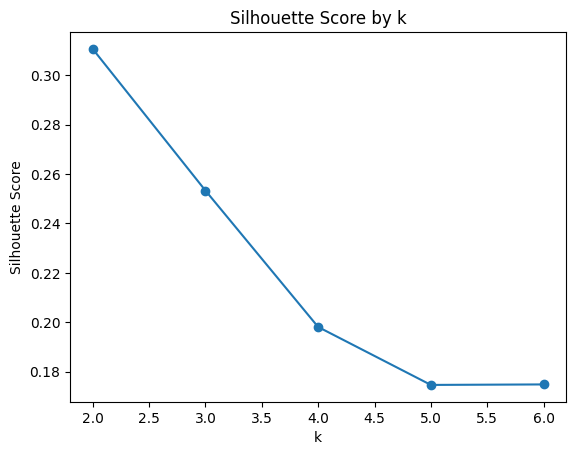

2

In [22]:
# find optimal k for home context
find_optimal_k(X_home)

In [23]:
kmeans_home = KMeans(n_clusters=2, random_state=123)
home_labels = kmeans_home.fit_predict(X_home)

# append the cluster labels to the 31Q dataset 
dat_final['HomeCluster'] = home_labels


### Social Environment 

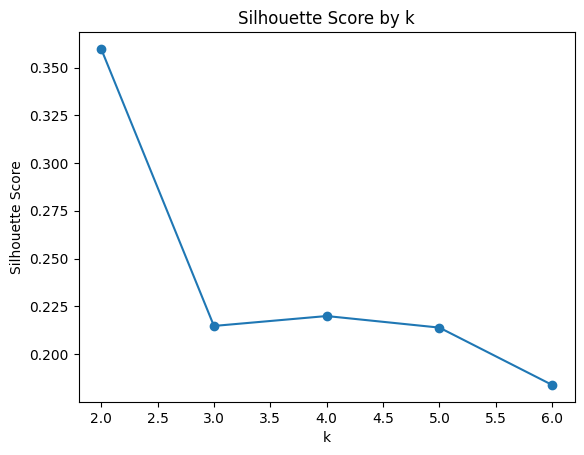

2

In [24]:
# find optimal k for home context
find_optimal_k(X_social)

In [25]:
kmeans_social = KMeans(n_clusters=2, random_state=123)
social_labels = kmeans_social.fit_predict(X_social)

# append the cluster labels to the 31Q dataset 
dat_final['SocialCluster'] = social_labels

### Phyiscal Health 

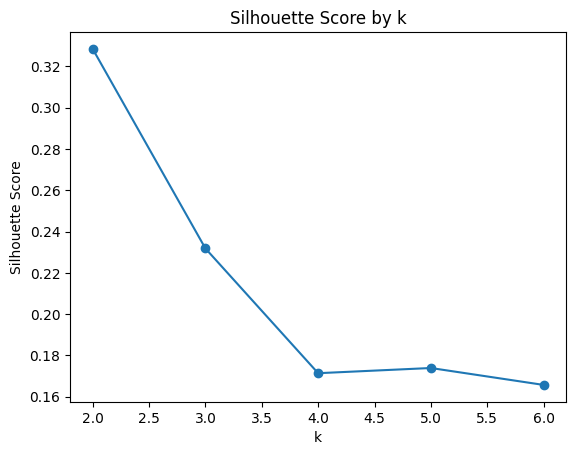

2

In [26]:
# find optimal k for home context
find_optimal_k(X_health)

In [27]:
kmeans_health= KMeans(n_clusters=2, random_state=123)
health_labels = kmeans_health.fit_predict(X_health)

# append the cluster labels to the 31Q dataset 
dat_final['HealthCluster'] = health_labels

## Label Direction Consistency Note


In this analysis, we performed clustering on three distinct domains: **Home Environment**, **Social Environment**, and **Physical Health**. Each domain was analyzed separately to identify clusters of individuals based on their responses to relevant survey questions. Importantly, we included **mental health indicators in all three clustering models** to serve as a **contextual anchor**. This allowed us to examine how patterns of environmental and social risk factors co-occur with mental health burden. By embedding mental health features into each domain-specific analysis, the resulting clusters reflect not only contextual adversity but also its psychological impact—enabling more meaningful interpretations of psychosocial vulnerability.

To ensure **consistent interpretation across domains**, we retrospectively **re-mapped the `SocialCluster` labels** so that:

- `Cluster 0` = **High-risk / High mental distress**
- `Cluster 1` = **Low-risk / Low mental distress**

This adjustment was necessary because KMeans assigns **arbitrary numeric labels** to clusters. In the original output, the `SocialCluster` labels were reversed in meaning compared to `HomeCluster` and `HealthCluster`—with `SocialCluster 0` reflecting the **low-risk group**. While there was no technical error, remapping the labels improves clarity and interpretability when comparing across domains.

### Cluster Reassignment for Domain Subsets

To reflect the new label direction, we reassigned cluster labels to the domain-specific DataFrames as follows:


In [28]:
# Recode the social cluster labels in dat_final
dat_final['SocialCluster'] = dat_final['SocialCluster'].map({0: 1, 1: 0})

## Cluster Evaluation and Domain Comparison

### Cluster Proportions

In [29]:
dat_final['HomeCluster'].value_counts(normalize=True)


HomeCluster
1    0.71531
0    0.28469
Name: proportion, dtype: float64

In [30]:
dat_final['SocialCluster'].value_counts(normalize=True)

SocialCluster
1    0.784744
0    0.215256
Name: proportion, dtype: float64

In [31]:
dat_final['HealthCluster'].value_counts(normalize=True)

HealthCluster
1    0.779202
0    0.220798
Name: proportion, dtype: float64

### Cluster Profile Means (Interpretation)

In [32]:
home_context['HomeCluster'] = dat_final['HomeCluster']
home_context.groupby('HomeCluster').mean()

,Q26,Q27,Q28,Q29,Q30,Q84,Q106,Q89,Q90,Q91,Q99,Q100,Q101,Q102,Q104
HomeCluster,,,,,,,,,,,,,,,
0,0.902290,0.679389,0.564122,1.543511,0.411069,3.813359,0.871756,3.166794,2.053435,1.885878,1.772137,0.627099,0.700763,0.376718,1.987405
1,0.246392,0.042534,0.027647,1.005469,0.004861,2.474404,0.324472,1.740544,1.252620,1.128209,1.401944,0.167857,0.185933,0.108309,1.653501


| Cluster | Suggested Label                         |
| ------- | --------------------------------------- |
| 0       | “**High-risk (Adverse) Home Environment & High Mental Distress**”  |
| 1       | “**Low-risk (Stable/Nurturing) Home Environment & Low Mental Distress**” |


In [33]:
social_context['SocialCluster'] = dat_final['SocialCluster']
social_context.groupby('SocialCluster').mean()

,Q26,Q27,Q28,Q29,Q30,Q84,Q106,Q14,Q16,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q88,Q103,Q105
SocialCluster,,,,,,,,,,,,,,,,,,,
0,0.929833,0.800606,0.684503,1.717819,0.541141,3.899041,0.891974,1.608279,1.745078,0.336699,1.806159,2.390712,2.146896,1.922766,0.474003,0.441696,0.273094,3.148915,0.345280
1,0.296871,0.065633,0.042094,1.005262,0.005123,2.569371,0.367350,1.133481,1.271531,0.024508,1.059540,2.008723,1.624481,1.387981,0.126835,0.093187,0.030324,2.460676,0.153559


| Cluster | Suggested Label                         |
| ------- | --------------------------------------- |
| 0       | “**Socially Isolated & High Mental Distress**”|
| 1       | “**Socially Supported & Low Mental Distress**” |


In [34]:
health_context['HealthCluster'] = dat_final['HealthCluster']
health_context.groupby('HealthCluster').mean()

,Q26,Q27,Q28,Q29,Q30,Q84,Q106,Q76,Q77,Q78,Q85
HealthCluster,,,,,,,,,,,
0,0.930610,0.888287,0.737205,1.709646,0.536909,3.894685,0.891732,4.550689,4.245079,3.301673,1.333661
1,0.292149,0.035560,0.022591,1.002510,0.002510,2.561149,0.363687,3.806303,3.892484,3.031097,0.720123


| Cluster | Suggested Label                                           |
| ------- | --------------------------------------------------------- |
| 0       | “**Low Phyisical Activity & High Mental Risk**” |
| 1       | “**High Phyisical Activity & Low Mental Risk**”   |


### Cluster Overlap Across Domains


In [35]:
pd.crosstab(dat_final['HomeCluster'], dat_final['SocialCluster'])

SocialCluster,0,1
HomeCluster,,
0,1782,838
1,199,6384


In [36]:
pd.crosstab(dat_final['HomeCluster'], dat_final['HealthCluster'])

HealthCluster,0,1
HomeCluster,,
0,1868,752
1,164,6419


In [37]:
pd.crosstab(dat_final['SocialCluster'], dat_final['HealthCluster'])

HealthCluster,0,1
SocialCluster,,
0,1679,302
1,353,6869


### Average Within-Cluster Distances

In [38]:
def average_within_cluster_distance(X, labels):
    dists = []
    for c in np.unique(labels):
        members = X[labels == c]
        dist = pairwise_distances(members).mean()
        dists.append(dist)
    return dists

average_within_cluster_distance(X_home, dat_final['HomeCluster'].values)


[np.float64(6.116005923163655), np.float64(3.799136759216432)]

In [39]:
average_within_cluster_distance(X_social, dat_final['SocialCluster'].values)    


[np.float64(8.163594571806243), np.float64(4.155247993542639)]

In [40]:
average_within_cluster_distance(X_health, dat_final['HealthCluster'].values)

[np.float64(4.8893490323763515), np.float64(3.57038690562652)]

## Visualizations & Tables

### Cluster PCA Plots

In [48]:
def plot_clusters(X, labels, title='', label_desc=None):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    var_ratio = pca.explained_variance_ratio_ * 100

    # Compute label proportions
    proportions = pd.Series(labels).value_counts(normalize=True).sort_index()

    # Map cluster labels to descriptive names
    label_names = {
        0: f"Cluster 0: {label_desc[0]} ({proportions[0]:.1%})",
        1: f"Cluster 1: {label_desc[1]} ({proportions[1]:.1%})"
    }
    labeled_series = pd.Series(labels).map(label_names)

    # Plot
    custom_palette = ['#2c3e50', '#a3b18a']
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labeled_series, palette=custom_palette)
    plt.title(title)
    plt.xlabel(f'PC1 ({var_ratio[0]:.1f}% variance)')
    plt.ylabel(f'PC2 ({var_ratio[1]:.1f}% variance)')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()



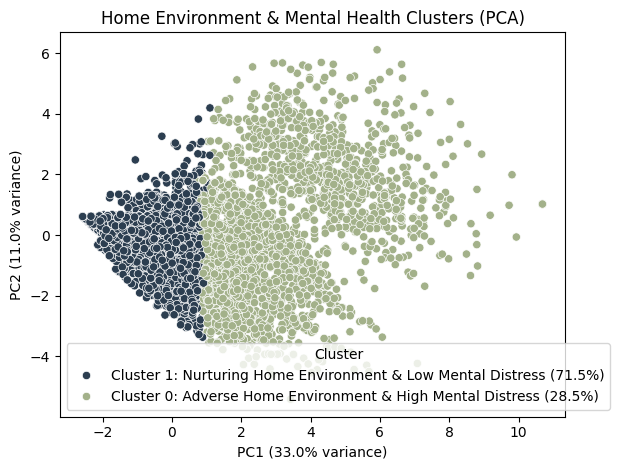

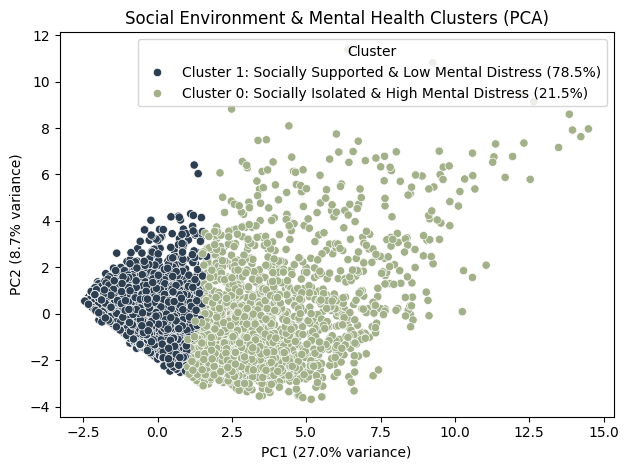

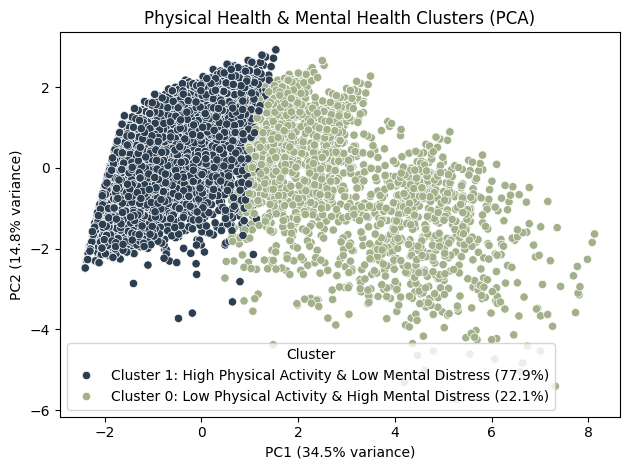

In [49]:
plot_clusters(
    X_home,
    dat_final['HomeCluster'],
    title='Home Environment & Mental Health Clusters (PCA)',
    label_desc=[
        'Adverse Home Environment & High Mental Distress',
        'Nurturing Home Environment & Low Mental Distress'
    ]
)

plot_clusters(
    X_social,
    dat_final['SocialCluster'],
    title='Social Environment & Mental Health Clusters (PCA)',
    label_desc=[
        'Socially Isolated & High Mental Distress',
        'Socially Supported & Low Mental Distress'
    ]
)

plot_clusters(
    X_health,
    dat_final['HealthCluster'],
    title='Physical Health & Mental Health Clusters (PCA)',
    label_desc=[
        'Low Physical Activity & High Mental Distress',
        'High Physical Activity & Low Mental Distress'
    ]
)


### Cluster Overlap Heatmap

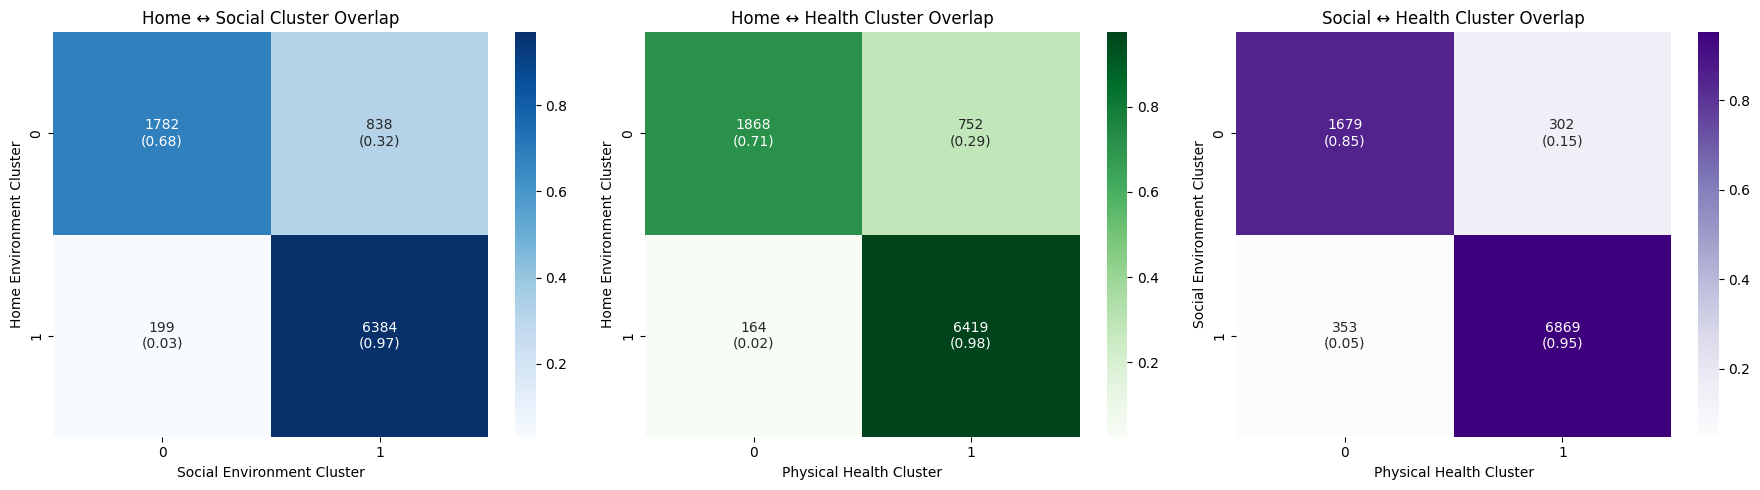

In [43]:
# Helper function to create annotations
def make_annotated_heatmap(row_var, col_var):
    counts = pd.crosstab(dat_final[row_var], dat_final[col_var])
    props = pd.crosstab(dat_final[row_var], dat_final[col_var], normalize='index')
    annotations = counts.astype(str) + "\n(" + props.round(2).astype(str) + ")"
    return props, annotations

# Prepare all three annotated heatmaps
ct_home_social, ann_home_social = make_annotated_heatmap('HomeCluster', 'SocialCluster')
ct_home_health, ann_home_health = make_annotated_heatmap('HomeCluster', 'HealthCluster')
ct_social_health, ann_social_health = make_annotated_heatmap('SocialCluster', 'HealthCluster')

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Home vs Social
sns.heatmap(ct_home_social, annot=ann_home_social, fmt='', cmap='Blues', ax=axes[0])
axes[0].set_title('Home ↔ Social Cluster Overlap')
axes[0].set_xlabel('Social Environment Cluster')
axes[0].set_ylabel('Home Environment Cluster')

# Home vs Health
sns.heatmap(ct_home_health, annot=ann_home_health, fmt='', cmap='Greens', ax=axes[1])
axes[1].set_title('Home ↔ Health Cluster Overlap')
axes[1].set_xlabel('Physical Health Cluster')
axes[1].set_ylabel('Home Environment Cluster')

# Social vs Health
sns.heatmap(ct_social_health, annot=ann_social_health, fmt='', cmap='Purples', ax=axes[2])
axes[2].set_title('Social ↔ Health Cluster Overlap')
axes[2].set_xlabel('Physical Health Cluster')
axes[2].set_ylabel('Social Environment Cluster')

plt.tight_layout()
plt.show()


### Silhouette Plots

In [44]:
custom_palette = ['#2c3e50', '#a3b18a']
def plot_silhouette(X, labels, title='Silhouette Plot'):
    silhouette_vals = silhouette_samples(X, labels)
    avg_score = silhouette_score(X, labels)
    n_clusters = len(np.unique(labels))

    fig, ax = plt.subplots(figsize=(6, 4))
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_vals = silhouette_vals[labels == i]
        ith_cluster_vals.sort()
        size_cluster_i = ith_cluster_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = custom_palette[i]

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_vals, facecolor=color, edgecolor='gray', alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10

    ax.axvline(x=avg_score, color="red", linestyle="--")
    ax.set_title(f"{title}\nAvg Silhouette Score: {avg_score:.2f}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Clustered Samples")
    ax.set_xlim([-0.1, 1])
    plt.tight_layout()
    plt.show()

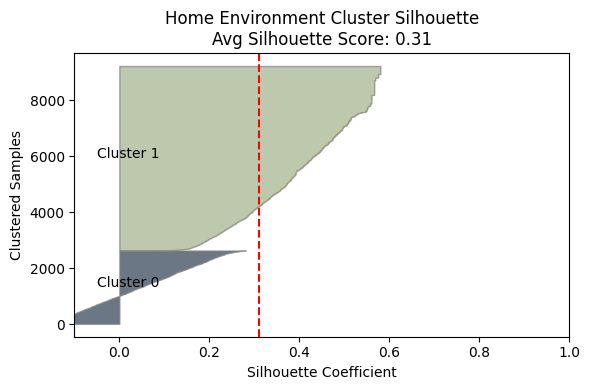

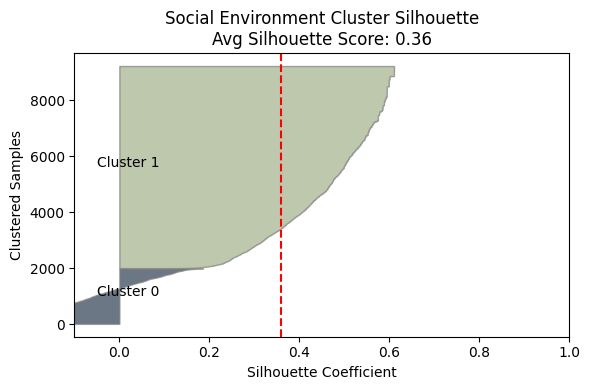

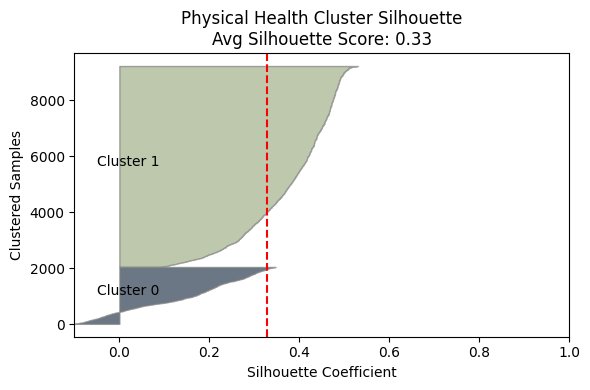

In [45]:
plot_silhouette(X_home, dat_final['HomeCluster'], title='Home Environment Cluster Silhouette')
plot_silhouette(X_social, dat_final['SocialCluster'], title='Social Environment Cluster Silhouette')
plot_silhouette(X_health, dat_final['HealthCluster'], title='Physical Health Cluster Silhouette')


### Cluster Summary Table

In [47]:
def cluster_summary(domain_name, labels, X, dists, label_desc):
    counts = pd.Series(labels).value_counts(normalize=True).sort_index() * 100
    sil_score = silhouette_score(X, labels)
    return {
        'Domain': domain_name,
        'Cluster 0 Size (%)': f"{counts[0]:.1f}%",
        'Cluster 1 Size (%)': f"{counts[1]:.1f}%",
        'Avg Dist (C0)': round(dists[0], 2),
        'Avg Dist (C1)': round(dists[1], 2),
        'Silhouette Score': round(sil_score, 3),
        'Label C0': label_desc[0],
        'Label C1': label_desc[1]
    }


summary_rows = []

summary_rows.append(cluster_summary(
    'Home',
    dat_final['HomeCluster'],
    X_home,
    average_within_cluster_distance(X_home, dat_final['HomeCluster'].values),
    ['Adverse Home Environment & High Mental Distress', 'Nurturing Home Environment & Low Mental Distress']
))

summary_rows.append(cluster_summary(
    'Social',
    dat_final['SocialCluster'],
    X_social,
    average_within_cluster_distance(X_social, dat_final['SocialCluster'].values),
    ['Socially Isolated & High Mental Distress', 'Socially Supported & Low Mental Distress']
))

summary_rows.append(cluster_summary(
    'Health',
    dat_final['HealthCluster'],
    X_health,
    average_within_cluster_distance(X_health, dat_final['HealthCluster'].values),
    ['Low Physical Activity & High Mental Distress', 'High Physical Activity & Low Mental Distress']
))

summary_df = pd.DataFrame(summary_rows)
summary_df

,Domain,Cluster 0 Size (%),Cluster 1 Size (%),Avg Dist (C0),Avg Dist (C1),Silhouette Score,Label C0,Label C1
0,Home,28.5%,71.5%,6.12,3.80,0.311,Adverse Home Environment & High Mental Distress,Nurturing Home Environment & Low Mental Distress
1,Social,21.5%,78.5%,8.16,4.16,0.360,Socially Isolated & High Mental Distress,Socially Supported & Low Mental Distress
2,Health,22.1%,77.9%,4.89,3.57,0.329,Low Physical Activity & High Mental Distress,High Physical Activity & Low Mental Distress


#### From CHAT GPT 

We conducted clustering across three domains—Home Environment, Social Environment, and Physical Health—to identify distinct psychosocial profiles based on survey responses. In each domain, two clusters emerged: one representing adverse conditions coupled with high mental distress, and the other reflecting nurturing or stable environments associated with low distress.

Notably, the majority of participants fell into the low-risk/low-distress cluster across all domains (Cluster 1: 71.5% in Home, 78.5% in Social, and 77.9% in Health), while the high-risk clusters (Cluster 0) were smaller but exhibited greater within-cluster variability, particularly in the Social domain (average distance = 8.16). This suggests that while high-risk individuals form a minority, their profiles are more diverse—especially in terms of social stress and support. These patterns support a dimensional model of vulnerability, where mental health distress co-occurs with distinct contextual adversities.

## Domain Specific Clustering Quality Analysis Conclusion

#### The clustering metrics look decent because:

- You have clear separation in the PCA space (the scatter plots show distinct clusters)
- The mathematical distances between cluster centers are reasonable
- Cluster sizes are fairly balanced (around 70-30 split)

#### But the clustering quality is actually poor because:

- **High overlap across domains**: Your confusion matrices show that the same individuals often belong to different clusters depending on which domain you're analyzing
- **Inconsistent cluster membership**: Someone might be in the "high risk" cluster for home environment but "low risk" cluster for health
- **Low silhouette score (0.31)**: This was actually telling you the truth - many data points are ambiguous in their cluster assignment

#### What this means:

Your clustering is capturing some real patterns in the data, but these patterns don't create clean, stable groups of people. Instead, you have individuals who might struggle in one domain (like home environment) but do well in others (like social connections).

This suggests that rather than having distinct "types" of people, your population might be better characterized by:

- Continuous risk gradients rather than discrete groups
- Domain-specific interventions rather than person-level classifications
- Multiple overlapping risk profiles rather than clear subtypes

# ------ MOVING FORWARD ------

# Working with Full Dataset

#### Data Exploration

In [ ]:
# Count missing values per column
missing_summary = dat.isnull().sum().sort_values(ascending=False)

# Percentage missing per column
missing_pct = (dat.isnull().mean() * 100).sort_values(ascending=False)

# Preview top 10 most missing
print(missing_summary.head(10))
print(missing_pct.head(10))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(dat.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()

In [ ]:
# Calculate percentage missing per column
missing_pct = dat.isnull().mean() * 100

# Filter columns with >50% missing
high_missing = missing_pct[missing_pct > 50].sort_values(ascending=False)

# Display them
print(f"{len(high_missing)} columns have more than 50% missing:\n")
print(high_missing)

In [ ]:
# Calculate percentage missing per column
missing_pct = dat.isnull().mean() * 100

# Filter columns with >40% missing
high_missing = missing_pct[missing_pct > 40].sort_values(ascending=False)

# Display them
print(f"{len(high_missing)} columns have more than 50% missing:\n")
print(high_missing)

#### Missingness and Dropping QN# and QNword columns

In [ ]:
# Step 1: Drop all QN# and QNword columns
qn_cols = [col for col in dat.columns if col.startswith('QN')]
dat2_step1 = dat.drop(columns=qn_cols)

# Step 2: Drop rows with any remaining missing values
dat2_cleaned = dat2_step1.dropna().copy()

print(f"Final shape of dat2_cleaned: {dat2_cleaned.shape}")

#### Recoding

•	Directional Binary\
•	Directional Reverse-Score (Ordinal)\
•	Neutral Numeric\
•	One-Hot\
•	Special Cases

14, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 76, 77, 78, 84, 85, 88, 89, 90, 91, 99, 100, 101, 102, 103, 104, 105, 106

In [ ]:
# Set working dataframe:
dat2_final = dat2_cleaned.copy()

# set as int


In [ ]:
dat2_final.info()

In [ ]:
# Binary
## Directional and Neutral Binary

binary_cols_dat2 = [
    'Q18', 'Q19', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q31',
    'Q35', 'Q88', 'Q100', 'Q101', 'Q102', 'Q105', 'Q106'
]

dat2_final = binary_recode(dat2_final, binary_cols_dat2)

In [ ]:
# Directional - Ordinal
## Reverse-Score

ordinal_cols_dat2 = [
    'Q8', 'Q76', 'Q77', 'Q78', 'Q96', 'Q97', 'Q99', 'Q104'
]

dat2_final = reverse_recode(dat2_final, ordinal_cols_dat2)

In [ ]:
# Neutral Numeric

def numeric_recode(df, neutral_cols):
    df = df.copy()
    for col in numeric_cols_dat2:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(int)
    return df

numeric_cols_dat2 = ['Q1', 'Q3']

dat2_final = numeric_recode(dat2_final, numeric_cols_dat2)